In [1]:
import pandas as pd
import numpy as np
import pyarrow.parquet as pq
import seaborn as sns
import ta
import plotly.graph_objs as go
from scipy.signal import argrelextrema
from datetime import datetime
from plotly.subplots import make_subplots

In [2]:
#Variáveis 
stop_gain_distance = 10 #distância do stop gain em pontos
stop_loss_distance = 10 #distância do stop loss em pontos
enable_RSI = 1 #0 ou 1 para habilitar RSI
rsi_period = 10 #período RSI
rsi_value = 30 #valor RSI
operation_time = 30 #duração máxima de uma operação
n_bars_validation = 15 #numero de barras para validar um pullback
extra_range_entry = 1 #range para entrar adiantado na operação

#Variáveis extras - dados do ativo WDO
value_per_pip = 10 #valor em R$ por variação de 1 ponto
order_tax = 1.33 #custo em R$ por ordem enviada
trade_hour_threshold = 17 #horário limite de trade 
trade_minute_threshold = 0 #minuto limite de trade
trade_volume = 1 #número de lotes/contratos
order_to_be_filled_threshold = 30 #tempo de limite para consumir a ordem existente

In [3]:
#Armazenando os dados do .parquet em estrutura pandas, do ativo WDO@N (mini dolar)
df = pq.ParquetFile("WDO_dados.parquet").read().to_pandas()
df.time = pd.to_datetime(df.time, format="%Y-%m-%d %H:%M:%S")
df = df.reset_index()

del df["tick_volume"]
del df["spread"]
del df["real_volume"]
del df["index"]

Cada amostra deste dataframe contém informação de um candle de 1 minuto. Note que Durante esse período de análise, o mercado passa por duas grandes fases: tendência de alta na primeira metade das amostras e tendência na segunda metade. Além disso, o método implementado abaixo busca apenas por oportunidades de compras.

<AxesSubplot:>

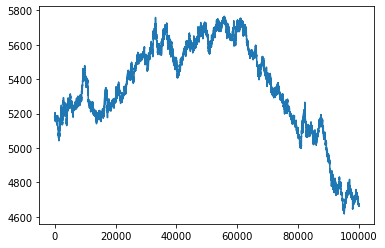

In [4]:
df.close.plot()

Nos próximos passos, para evitar o uso de For loop, irei utilizar métodos de vetorização providos do pandas e numpy, a fim de agilizar a velocidade código.

In [5]:
#criando local_max
local_max_index = np.array(argrelextrema(df.high.values, np.greater, order=15, mode='wrap')[0])

df['local_max'] = 0
df.loc[local_max_index, 'local_max'] = 1

#Obtendo index do local_high anterior
prev_high_index_array = df.iloc[df.local_max.values == 1].index.values
prev_high_index_array = np.roll(prev_high_index_array, 1)
prev_high_index_array[0] = 0

df['prev_high_index'] = 0
df.loc[local_max_index, 'prev_high_index'] = np.where(
  df.loc[df.local_max.values == 1].local_max.values,
  prev_high_index_array, 0
  )

A título de exemplo, aqui vai uma plotagem de um dia qualquer, sobre como foi gerado máximos locais. Para ser considerado um topo, a máxima do candle precisa ser maior que a máxima dos 15 candles anteriores e posteriores mais próximos.

In [6]:
#Plotando um exemplo da amostra: exibindo max locais

df2 = df[(df.time >= datetime(2022,3,31,0,0)) & (df.time <= datetime(2022,4,1,0))].copy()

fig = make_subplots(rows=2, cols=1, shared_xaxes=True, specs=[[{"secondary_y": False}], [{"secondary_y": True}]],
                    vertical_spacing=0.03, subplot_titles=('OHLC - 1 min timeframe', 'Volume'), row_width=[0.2, 0.7])
                    
fig.add_trace(go.Candlestick(x=df2.time, open=df2['open'], high=df2['high'], low=df2['low'], close=df2['close'], name="Candle"), row=1, col=1)
fig.add_trace(go.Scatter(x=df2[df2["local_max"] == 1].time, y=df2[df2["local_max"] == 1]["high"], name="Topo Local", mode="markers", marker_color="cyan", marker_symbol="x", marker_size=15, opacity=0.5), row=1, col=1)

fig.update_layout(template="plotly_dark", xaxis_rangeslider_visible=False, height=700)
fig.update_xaxes(rangebreaks=[dict(bounds=["sat", "mon"]), dict(bounds=[18, 9], pattern="hour")])

fig.show()

In [7]:
#Obtendo index que corresponde ao horário limite de trade
total_min_threshold = trade_hour_threshold*60 + trade_minute_threshold

daily_min = df.iloc[local_max_index].time.values.astype('datetime64[m]') - df.iloc[local_max_index].time.dt.normalize().values.astype('datetime64[m]')
search_index_array = total_min_threshold - daily_min 

df['search_index'] = 0
df.loc[local_max_index, 'search_index'] = np.where(
  df.loc[df.local_max.values == 1].local_max.values,
  search_index_array, 0
  )

In [8]:
#Habilitando apenas calculo de canais diários
search_index_array = search_index_array.astype('int32')

isNewDay_array = np.where(
  np.roll(search_index_array, 1) < search_index_array,
  True,False
  )

df['isNewDay'] = False
df.loc[local_max_index, 'isNewDay'] = np.where(
  df.loc[df.local_max.values == 1].local_max.values,
  isNewDay_array, False
  )

No passo a seguir, a ideia é filtrar o dataframe para buscar as informações iniciais necessárias para os cálculos de quebra de canal de tendência, armazenando-as no array useful_calc_info. Cada item deste array irá conter os seguintes elementos: high do segundo index, valor do segundo index, high do primeiro index, valor do segundo index e valor de índice adicional para o range de pesquisa futuro, respectivamente.  

In [9]:
#filtrando candidatos a calculos
conditions = [
  (df.iloc[local_max_index].local_max == 1) &
  (df.iloc[local_max_index].search_index > 0) &
  (df.iloc[local_max_index].isNewDay == False)
]

filtered_index_array = np.select(conditions, [df.iloc[local_max_index].index], default = 0)
filtered_index_array = filtered_index_array[filtered_index_array != 0]

#criando array com informações necessárias para o cálculo de breakout
useful_calc_info = df.iloc[filtered_index_array].apply(
  lambda x: (df.iloc[x.prev_high_index].high, x.high,x.prev_high_index, x.name, x.search_index),
  axis=1)

useful_calc_info = useful_calc_info.to_numpy(dtype=object)

In [10]:
#função que simula corretamente o valor de envio de ordem
def round_limit_order_price(limitOrderPrice):
  decimal_value = limitOrderPrice % 1

  if decimal_value > 0.25 and decimal_value <= 0.5:
    limitOrderPrice = float(round(limitOrderPrice) + 0.5)
  elif decimal_value > 0.5 and decimal_value <= 0.75:
    limitOrderPrice = float(round(limitOrderPrice) - 0.5)
  else:
    limitOrderPrice = float(round(limitOrderPrice))

  return limitOrderPrice

#função que executa a fórmula de cálculo do candle atual em relação aos 2 últimos topos
def calculateChannelResistance(barDistance_pips, current_position, barDistance_range, first_point_value):
  lineVariation = (barDistance_pips*(barDistance_range+current_position))/barDistance_range
  channelResistance = first_point_value - lineVariation
  return channelResistance

No seguinte passo, utilizarei o array useful_calc_info, de tamanho n, para percorrer n canais de tendências, buscando possíveis entradas, que são criadas apenas se acionar a ordem limite, criada após uma validação de pullback, posterior a um breakout do respectivo canal de tendência. As regras são as seguintes:

1. O breakout ocorre quando o candle atual possuir high maior que o valor do canal de tendência (sua resistência);
2. Validação do pullback ocorre se, nos próximos x minutos, a mímina do candle é superior ao canal de tendência;
3. Ordem limite é gerada próximo ao canal de tendência, sendo atualizada a todo minuto e precisa ser acionado dentro de mais x minutos;
4. Ocorre a entrada apenas se a mínima do candle atual for inferior ou igual ao valor da ordem limite.

In [11]:
#calculando breakout, pullbacks e entradas
profit = np.array([])

df['rsi'] = ta.momentum.rsi(df.close, rsi_period)
df["local_entry"] = 0
df["entry_value"] = 0
df["exit"] = 0
df["exit_value"] = 0

for i in useful_calc_info:
  barDistance_pips = i[0] - i[1]
  barDistance_range = i[3] - i[2]

  starting_range = i[3]+1
  ending_range = i[3] + i[4]

  positionsTotal = False
  ordersTotal = False
  orderRunner=0
  
  #validando breakout
  for row in df.iloc[starting_range:ending_range+1].index.values:
    channelResistance = calculateChannelResistance(barDistance_pips, row-i[3], barDistance_range, i[0])

    #validando breakout
    if df.close.iloc[row] > channelResistance:
      row += n_bars_validation-1
      channelResistance = calculateChannelResistance(barDistance_pips, row-i[3], barDistance_range, i[0])
      
      #validando pullback
      if(df.low.iloc[row] > channelResistance):
        ordersTotal = True

      break

  #verificando possível entrada pelo pullback (considerando ordem enviada)
  if ordersTotal == True:
    for row in df.iloc[row+1:ending_range+1].index.values:

      orderRunner +=1
      channelResistance = calculateChannelResistance(barDistance_pips, row-i[3], barDistance_range, i[0])

      limitOrderPrice = channelResistance+extra_range_entry
      limitOrderPrice = round_limit_order_price(limitOrderPrice)

      #se ativar ordem, cai aqui
      if (df.low.iloc[row] <= limitOrderPrice):
        if (enable_RSI == 1):
            if (df.rsi.iloc[row] > rsi_value):
                df.loc[row, 'local_entry'] = 1 
                df.loc[row, 'entry_value'] = limitOrderPrice 
                row_value = row
                positionsTotal = True
                break

        else:
            df.loc[row, 'local_entry'] = 1 
            df.loc[row, 'entry_value'] = limitOrderPrice 
            row_value = row
            positionsTotal = True
            break
        
      elif orderRunner > order_to_be_filled_threshold:
        break
    
  if (positionsTotal == True):
    operation_timer = 0 
    for row in df.iloc[row+1:(row+1+operation_time)].index.values:
      operation_timer += 1

      stop_gain = limitOrderPrice+stop_gain_distance
      stop_loss = limitOrderPrice-stop_loss_distance

      if df.high.iloc[row] >= stop_gain:
        df.loc[row, 'exit'] = 1 
        df.loc[row, 'exit_value'] = stop_gain
        profit = np.append(profit, (stop_gain_distance*value_per_pip*trade_volume)-(order_tax*2*trade_volume))
        break

      elif df.low.iloc[row] <= stop_loss:
        df.loc[row, 'exit'] = 1
        df.loc[row, 'exit_value'] = stop_loss
        profit = np.append(profit, ((-stop_loss_distance)*value_per_pip*trade_volume)-(order_tax*2*trade_volume))
        break

      elif operation_timer == operation_time:
        df.loc[row, 'exit'] = 1
        df.loc[row, 'exit_value'] = df.close.iloc[row]
        profit = np.append(profit, ((df.close.iloc[row] - limitOrderPrice)*value_per_pip*trade_volume)-(order_tax*2*trade_volume))
        break


In [12]:
#Exibindo informações dos trades dentro da série histórica

profit = pd.DataFrame(profit, columns=["profit_per_trade"])
profit[['cum_sum']] = profit['profit_per_trade'].cumsum()
profit['positive_trades'] = np.where(profit.profit_per_trade > 0, profit.profit_per_trade, 0)
profit['negative_trades'] = np.where(profit.profit_per_trade <= 0, profit.profit_per_trade, 0)

results_array = np.array(
    [round(profit.cum_sum.iloc[-1],2),
    len(profit),
    round(len(profit[profit.positive_trades > 0])/len(profit),2),
    round(abs(profit['positive_trades'].mean()/profit['negative_trades'].mean()),2),
    round(profit.profit_per_trade.mean(),2),
    round(profit.profit_per_trade.std(),2)]
    )

df_results = pd.DataFrame(columns=[
    'Saldo Líquido',
    'Número de entradas',
    'Taxa de acerto',
    'Payoff',
    'Média de lucro por operação',
    "Desvio padrão"])

df_results = df_results.append(pd.DataFrame(results_array.reshape(1,-1), columns=list(df_results)), ignore_index=True)

print("Período:", df.iloc[0].time.strftime('%Y-%m-%d %X'), "-", df.iloc[-1].time.strftime('%Y-%m-%d %X'), "\n", df_results.iloc[0])


Período: 2021-07-26 16:51:00 - 2022-04-18 17:59:00 
 Saldo Líquido                  2614.30
Número de entradas              145.00
Taxa de acerto                    0.62
Payoff                            1.70
Média de lucro por operação      18.03
Desvio padrão                    76.63
Name: 0, dtype: float64


<AxesSubplot:>

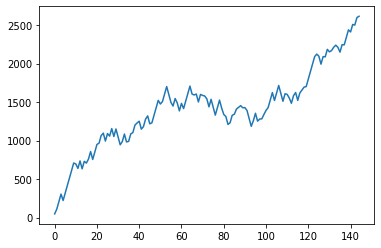

In [13]:
#Exibindo evolução do patrimonio sobre o acumulado de operações
profit["cum_sum"].plot()

Abaixo, será plotado um histograma que conta o número de ocorrências dos resultados de cada operação. As operações que não atingiram os alvos de stop gain ou stop loss foram aquelas que extrapolaram o limite máximo de duração de trade.

<AxesSubplot:xlabel='profit_per_trade', ylabel='Count'>

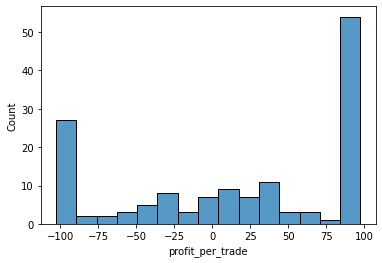

In [14]:
sns.histplot(profit.profit_per_trade, bins=15)

In [15]:
#Plotando um exemplo da amostra: exibindo max locais, entradas e saídas

dateBegin =  datetime(2022,1,24,0,0)
dateEnd = datetime(2022,1,25,0)

df2 = df[(df.time >= dateBegin) & (df.time <= dateEnd)].copy()

fig = make_subplots(rows=2, cols=1, shared_xaxes=True, specs=[[{"secondary_y": False}], [{"secondary_y": True}]],
                    vertical_spacing=0.03, subplot_titles=('OHLC - 1 min timeframe', 'Volume'), row_width=[0.2, 0.7])
                    
fig.add_trace(go.Candlestick(x=df2.time, open=df2['open'], high=df2['high'], low=df2['low'], close=df2['close'], name="Candle"), row=1, col=1)
fig.add_trace(go.Scatter(x=df2[df2["local_max"] == 1].time, y=df2[df2["local_max"] == 1]["high"], name="Topo Local", mode="markers", marker_color="cyan", marker_symbol="x", marker_size=15, opacity=0.5), row=1, col=1)
fig.add_trace(go.Scatter(x=df2[df2["local_entry"] == 1].time, y=df2[df2["local_entry"] == 1]["entry_value"], name="Compra", mode="markers", marker_color="green", marker_symbol="circle", marker_size=15, opacity=0.5), row=1, col=1)
fig.add_trace(go.Scatter(x=df2[df2["exit"] == 1].time, y=df2[df2["exit"] == 1]["exit_value"], name="Venda", mode="markers", marker_color="red", marker_symbol="square", marker_size=15, opacity=0.5), row=1, col=1)

fig.update_layout(template="plotly_dark", xaxis_rangeslider_visible=False, height=700)
fig.update_xaxes(rangebreaks=[dict(bounds=["sat", "mon"]), dict(bounds=[18, 9], pattern="hour")])

fig.show()

Note como exemplo que, a compra no horário 11:27 foi habilitada devido ao breakout + pullback de um canal criada pelos topos de 9:21 e 10:10. Para visualizar mais resultados, basta verificar pelos horários de entradas ocorridos e plotá-los. Use df.iloc[df.local_entry.values == 1].time para escanear mais entradas!